# Approach

* Firstly a convolutional neural network is used to segment the image, using the bounding boxes directly as a mask. 
* Secondly connected components is used to separate multiple areas of predicted pneumonia.
* Finally a bounding box is simply drawn around every connected component.

# Network

* The network consists of a number of residual blocks with convolutions and downsampling blocks with max pooling.
* At the end of the network a single upsampling layer converts the output to the same shape as the input.

As the input to the network is 256 by 256 (instead of the original 1024 by 1024) and the network downsamples a number of times without any meaningful upsampling (the final upsampling is just to match in 256 by 256 mask) the final prediction is very crude. If the network downsamples 4 times the final bounding boxes can only change with at least 16 pixels.

**Edit by EAS** - Change input image size to 320x320.

In [0]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip install -q pydicom 
!pip install -q imgaug 
!pip install -q kaggle
!pip install -q tqdm 
!pip install -q PyDrive

In [0]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt

In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {
      'name': name,
      'mimeType': 'application/octet-stream'
     }

    media = MediaFileUpload(path, 
                    mimetype='application/octet-stream',
                    resumable=True)

    created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created

In [0]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

In [5]:
# If you are unable to download the competition dataset, check to see if you have 
# accepted the user agreement on the competition website. 
if not os.path.exists("./stage_1_detailed_class_info.csv.zip"):
  !kaggle competitions download -c rsna-pneumonia-detection-challenge

  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 36.7kB/s]
  0% 0.00/561k [00:00<?, ?B/s]
100% 561k/561k [00:00<00:00, 51.6MB/s]
  0% 0.00/51.8k [00:00<?, ?B/s]
100% 51.8k/51.8k [00:00<00:00, 38.8MB/s]
  0% 0.00/634k [00:00<?, ?B/s]
100% 634k/634k [00:00<00:00, 81.5MB/s]
 90% 114M/126M [00:02<00:00, 39.0MB/s]
100% 126M/126M [00:02<00:00, 45.9MB/s]
100% 3.16G/3.17G [01:05<00:00, 70.9MB/s]
100% 3.17G/3.17G [01:05<00:00, 51.7MB/s]


In [6]:
# unzipping takes a few minutes
if not os.path.exists("./stage_1_train_labels.csv"):
  print("Unzipping...")
  !unzip -q -o stage_1_test_images.zip -d stage_1_test_images
  !unzip -q -o stage_1_train_images.zip -d stage_1_train_images
  !unzip -q -o stage_1_train_labels.csv.zip

Unzipping...


# Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row. 
* If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations. 
* If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary. 
* The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. 
* If a filename is not present in the dictionary it means that it contains no pneumonia.

In [5]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('./stage_1_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

# Load filenames

In [7]:
random.seed(a=1)
# load and shuffle filenames
folder = './stage_1_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 23124
n valid samples 2560


 # Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.
    

In [0]:
BATCH_SIZE = 12
IMAGE_SIZE = 384
CHECKPOINT_PATH = "model7_384.h5"

In [9]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp gs://{bucket_name}/{CHECKPOINT_PATH} ./{CHECKPOINT_PATH}

Updated property [core/project].
CommandException: No URLs matched: gs://pneumonia/model7_384.h5


In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
            
        # small shifts to images
        if self.augment:
            h_offset = np.random.randint(low=0, high=10)
            v_offset = np.random.randint(low=0, high=10)
            # crop the images
            img = img[v_offset:,h_offset:]
            msk = msk[v_offset:,h_offset:]
            
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

# Network

In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        
        if channels > 384:
          channels = 384
        
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
            
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Dropout(0.20)(x)
    
    x_2 = keras.layers.Conv2D(512, (3,3), padding='same', dilation_rate=(2,2), activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_2)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(512, (3,3), padding='same', dilation_rate=(2,2), activation=None)(x)
    # residual connection
    x = keras.layers.add([x, x_2])
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(256, 1, activation=None, kernel_regularizer=keras.regularizers.l2(l=0.01))(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Train network


In [13]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 20
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
checkpoint = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

# create train and validation generators
folder = './stage_1_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 384, 384, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 384, 384, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 384, 384, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [0]:
model.load_weights(CHECKPOINT_PATH)

In [14]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=5, shuffle=True, verbose=1)

Epoch 1/5
1926/1927 [============================>.] - ETA: 1s - loss: 0.5630 - acc: 0.9602 - mean_iou: 0.5890
Epoch 00001: saving model to model7_384.h5
1927/1927 [==============================] - 2433s 1s/step - loss: 0.5630 - acc: 0.9602 - mean_iou: 0.5890 - val_loss: 0.5743 - val_acc: 0.9728 - val_mean_iou: 0.7568
Epoch 2/5
1926/1927 [============================>.] - ETA: 1s - loss: 0.4820 - acc: 0.9618 - mean_iou: 0.6161
Epoch 00002: saving model to model7_384.h5
1927/1927 [==============================] - 2406s 1s/step - loss: 0.4819 - acc: 0.9618 - mean_iou: 0.6162 - val_loss: 0.4761 - val_acc: 0.9701 - val_mean_iou: 0.7058
Epoch 3/5
1926/1927 [============================>.] - ETA: 1s - loss: 0.4673 - acc: 0.9643 - mean_iou: 0.6409
Epoch 00003: saving model to model7_384.h5
1927/1927 [==============================] - 2405s 1s/step - loss: 0.4672 - acc: 0.9643 - mean_iou: 0.6410 - val_loss: 0.4612 - val_acc: 0.9589 - val_mean_iou: 0.6099
Epoch 4/5
1926/1927 [================

In [0]:
# history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=3, shuffle=True, verbose=1)

Epoch 1/3
1926/1927 [============================>.] - ETA: 1s - loss: 0.4402 - acc: 0.9675 - mean_iou: 0.6664
Epoch 00001: saving model to model7_384.h5
1927/1927 [==============================] - 2413s 1s/step - loss: 0.4402 - acc: 0.9675 - mean_iou: 0.6665 - val_loss: 0.4458 - val_acc: 0.9718 - val_mean_iou: 0.7105
Epoch 2/3
1669/1927 [========================>.....] - ETA: 5:05 - loss: 0.4363 - acc: 0.9678 - mean_iou: 0.6675

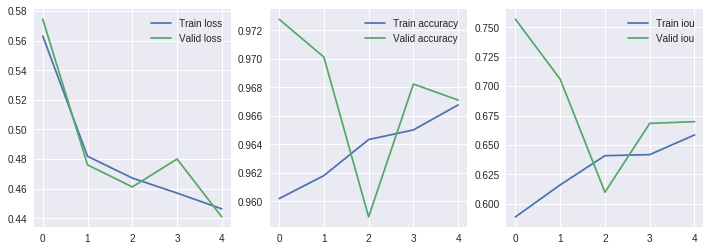

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

## Sample Predictions

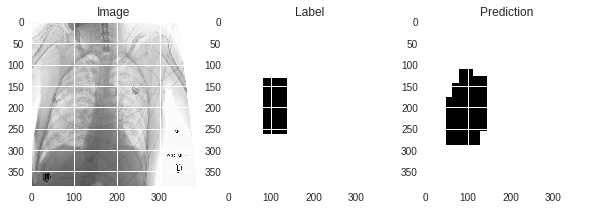

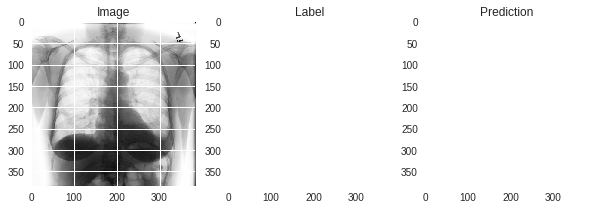

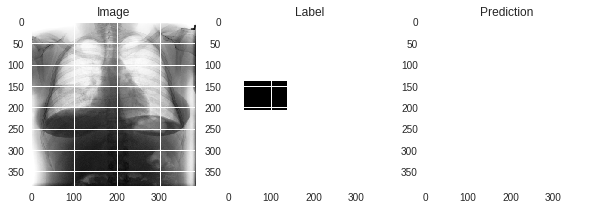

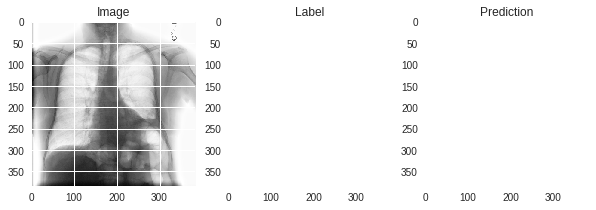

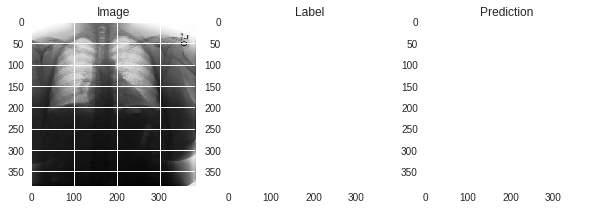

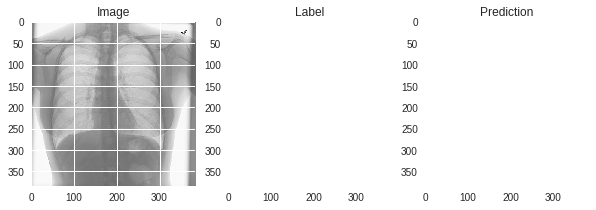

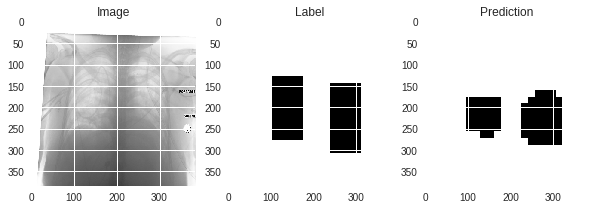

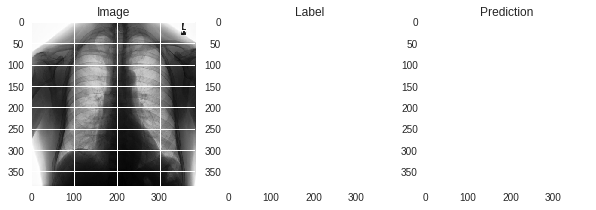

In [22]:
THRESHOLD = 0.5
# look at some sample predictions
samples = np.random.choice(valid_filenames, size=8, replace=False)

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join(train_dicom_dir, filename)).pixel_array
    
    msk = np.zeros(img.shape)
    
    filename = filename.split('.')[0]
    # if image contains pneumonia
    if filename in pneumonia_locations:
        # loop through pneumonia
        for location in pneumonia_locations[filename]:
            # add 1's at the location of the pneumonia
            x, y, w, h = location
            msk[y:y+h, x:x+w] = 1
        
    # resize both image and mask
    msk = resize(msk, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect') > 0.5
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
    
    # predict the image
    yhat = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    yhat = yhat > THRESHOLD
    # add trailing channel dimension
    msk = np.expand_dims(msk, -1)

    f, ax = plt.subplots(1, 3, figsize=(10, 4))
    ax[0].imshow(img.reshape(IMAGE_SIZE,IMAGE_SIZE))
    ax[0].set_title("Image")
    ax[1].imshow(msk.reshape(IMAGE_SIZE,IMAGE_SIZE))
    ax[1].set_title("Label")
    ax[2].imshow(yhat.reshape(IMAGE_SIZE,IMAGE_SIZE))
    ax[2].set_title("Prediction")
    plt.show()
    

# Predict test images

In [23]:
THRESHOLD = 0.5

# load and shuffle filenames
folder = './stage_1_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=IMAGE_SIZE, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        
        # threshold predicted mask
        comp = pred[:, :, 0] > THRESHOLD
        
        # apply connected components
        comp = measure.label(comp)
        
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
        
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')

n test samples: 1000


In [24]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f submission.csv -m "Colab segmentation v3 384x384 5 epochs th 0.3"

Successfully submitted to RSNA Pneumonia Detection Challenge

In [19]:
save_file_to_drive("submission.csv", "submission.csv")
save_file_to_drive(CHECKPOINT_PATH, CHECKPOINT_PATH)

File ID: 1uuhyHl5E0wDSvSyro2m0nnMyqN3Fvj4F
File ID: 1US_q0WXu6v66sKUYzT3lypP6aDaifEHJ


{'id': '1US_q0WXu6v66sKUYzT3lypP6aDaifEHJ'}

In [20]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp ./{CHECKPOINT_PATH} gs://{bucket_name}/

Updated property [core/project].
Copying file://./model7_384.h5 [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/49.2 MiB.                                     
